# Single cell proteomics script 
- Code generation using AI assistance, human customisation and review
- Code summary of analysis from July 2025, November 20205, and December 2025
- Filter steps such as the exclusion of proteins with more than 70% missing values were used.
- The analysis was performed using knn imputation to handle missing values. Further analyses using different imputation methods are in progress. 
- Cluster optimisation was performed using the silhouette score, Calinski-Harabasz index and Davies-Bouldin index, but manually applied to 4 instead of 2, based on visual analysis of the plots.
- Outliers were identified using the EllipticEnvelope method.

- open points and ongoing analysis:
    * Batch correction needed? 
    * testing different imputaion methods
    * FDR correction
    * log transformation needed?


In [4]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, davies_bouldin_score)
from sklearn.covariance import EllipticEnvelope
from scipy.stats import f_oneway
from pathlib import Path
import pandas as pd
import statsmodels.api as sm # for NIPALS comparision
import warnings
warnings.filterwarnings('ignore')


# Configure plotting style for figures
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
plt.rcParams.update({
    "figure.figsize": (12, 8),
    "font.size": 11,
    "axes.linewidth": 1.2,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "figure.dpi": 150
})



In [5]:
# loading data/ quality-check and filter criteria

def load_and_filter_data(xlsx_path, protein_missing_threshold=0.7):
    """
    -> data in Excel -> structure:
      A: PG.ProteinAccessions
      B: PG.Genes
      C: PG.ProteinDescription  
      D: PG.ProteinNames
      E onwards: Intensities (NaN; columns = cells)
    """
    raw = pd.read_excel(xlsx_path, header=0)
    print(f"dataset: {raw.shape[0]} proteins × {raw.shape[1]-4} samples")    
    intens = raw.iloc[:, 4:]  #from column E onwards -> intensity data extraction

    protein_missing_rates = intens.isna().mean(axis=1)
    good_proteins = protein_missing_rates < protein_missing_threshold # filter based on threshold in function 0.7 -> test this for 0.1-0.8 based on iterature -> Not applied: exclusion of all cells with more than 50% missing values  
    intens_filtered = intens.loc[good_proteins, :]
    protein_accessions = raw.loc[good_proteins, raw.columns[0]]  # First column = accessions!
    
    # Transpose: rows = cells, columns = proteins
    matrix = intens_filtered.T
    matrix.columns = protein_accessions
    
    # Data cleaning
    matrix = matrix.apply(pd.to_numeric, errors="coerce")
    matrix = matrix.dropna(axis=1, how="all")  # empty protein removal
    matrix = matrix.dropna(axis=0, how="all")  # empty cell removal
    
    proteins_removed = (~good_proteins).sum()
    total_cells = matrix.size
    nan_per_protein = matrix.isna().sum(axis=0)
    protein_with_nan = (nan_per_protein > 0).sum()
    print(f"Proteins removed (≥{protein_missing_threshold*100:.0f}% missing): {proteins_removed}")
    print(f"Final dataset: {matrix.shape[0]} cells × {matrix.shape[1]} proteins")  
    print(f"all values: {total_cells:}")
    print(f"Missing values remaining: {matrix.isna().sum().sum()}")
    print(f"Missing value percentage: {(matrix.isna().sum().sum() / matrix.size) * 100:.2f}%")
    print(f"Protein with NaN: {protein_with_nan} von {matrix.shape[1]}")
      
    return matrix




In [6]:
# Load and filter the data
file_path = "C:/Users/urs.kindler/Desktop/Single Cell Proteomics/Filtered_singlecelldata_292samples_RH.xlsx" #"x.xlsx"
expression_matrix = load_and_filter_data(file_path, protein_missing_threshold=0.7)


dataset: 3707 proteins × 291 samples
Proteins removed (≥70% missing): 2439
Final dataset: 291 cells × 1268 proteins
all values: 368988
Missing values remaining: 104605
Missing value percentage: 28.35%
Protein with NaN: 1181 von 1268


In [7]:
# missing value handeling using imputation + data standarization

USE_IMPUTATION = True # imputation filter if false -> no imputation; issue: NaN in dataset prevent the downstream analysis. Therefore using NPALS PCA in different script for imputation comparision. NPALS PCA create a pca_scores for downstream analysis without using imputation.

def preprocess_data(expression_matrix, knn_neighbors=5, use_imputation=True):
    """
    - application of knn imputation with k=5 (often applied in sc Proteomics analysis)
    - Z-score standardization -> equal contribution of proteins for downstream analyses 

    expression_standardized : np.ndarray
        Imputed and standardized expression matrix
    original_df : pd.DataFrame
        Original dataframe for reference
    """   
    # KNN imputation
    if use_imputation and expression_matrix.isna().any().any():
        k = min(knn_neighbors, max(2, expression_matrix.shape[0] - 1))
        imputer = KNNImputer(n_neighbors=k)
        expression_imputed = imputer.fit_transform(expression_matrix)
        expression_imputed = pd.DataFrame(
            expression_imputed, 
            index=expression_matrix.index, 
            columns=expression_matrix.columns
        )
    else:
        expression_imputed = expression_matrix.copy()
        if not use_imputation:
            print("No imputation - original values")
        else:
            print("No missing values detected - skipping imputation")
    
    scaler = StandardScaler()
    expression_standardized = scaler.fit_transform(expression_imputed)
    print(f"Standardized data: {expression_standardized.shape}")
    
    return expression_standardized, expression_imputed

expression_standardized, expression_imputed = preprocess_data(expression_matrix, use_imputation=USE_IMPUTATION)



Standardized data: (291, 1268)


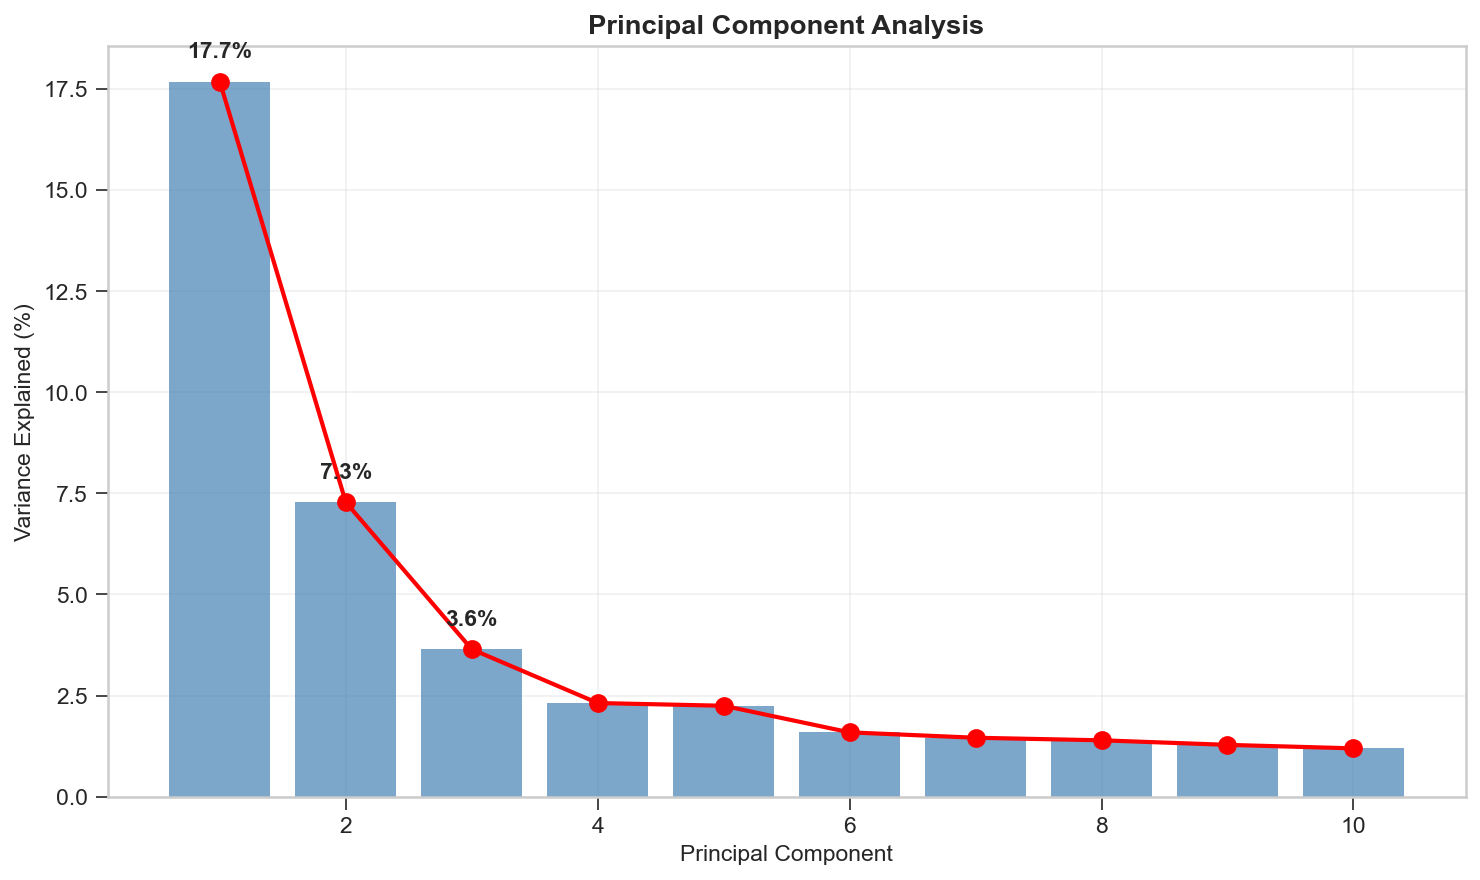

In [8]:
# PCA + variance analysis

def perform_pca_analysis(data, max_components=10):
    """
    PCA for dimensional reduction 
    output:
    pca_scores : np.ndarray
        Principal component scores
    explained_variance : np.ndarray
        Variance explained by each component
    pca : PCA
        Fitted PCA object
    """

    n_components = min(max_components, *data.shape)

    pca = PCA(n_components=n_components, random_state=42) # random_state=42 makes analysis reproducible
    pca_scores = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_ * 100
    
    return pca_scores, explained_variance, pca

# Perform PCA
pca_scores, explained_variance, pca_model = perform_pca_analysis(expression_standardized)

# polt PCA variance explanation
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color="steelblue", alpha=0.7)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, "ro-", linewidth=2, markersize=8)
plt.title("Principal Component Analysis", fontweight="bold")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.grid(True, alpha=0.3)

for i, var in enumerate(explained_variance[:3]):
    plt.text(i+1, var + 0.5, f"{var:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig("PCA_variance_explanation.pdf", dpi=300, format="pdf")
plt.show()

k=2: Silhouette=0.303, Calinski-Harabasz=94.9, Davies-Bouldin=1.536
k=3: Silhouette=0.248, Calinski-Harabasz=86.2, Davies-Bouldin=1.518
k=4: Silhouette=0.275, Calinski-Harabasz=79.7, Davies-Bouldin=1.339
k=5: Silhouette=0.251, Calinski-Harabasz=74.9, Davies-Bouldin=1.302
k=6: Silhouette=0.229, Calinski-Harabasz=73.8, Davies-Bouldin=1.404
k=7: Silhouette=0.247, Calinski-Harabasz=74.2, Davies-Bouldin=1.123
k=8: Silhouette=0.248, Calinski-Harabasz=74.6, Davies-Bouldin=1.247
k=9: Silhouette=0.255, Calinski-Harabasz=70.9, Davies-Bouldin=1.156
k=10: Silhouette=0.254, Calinski-Harabasz=69.7, Davies-Bouldin=1.254


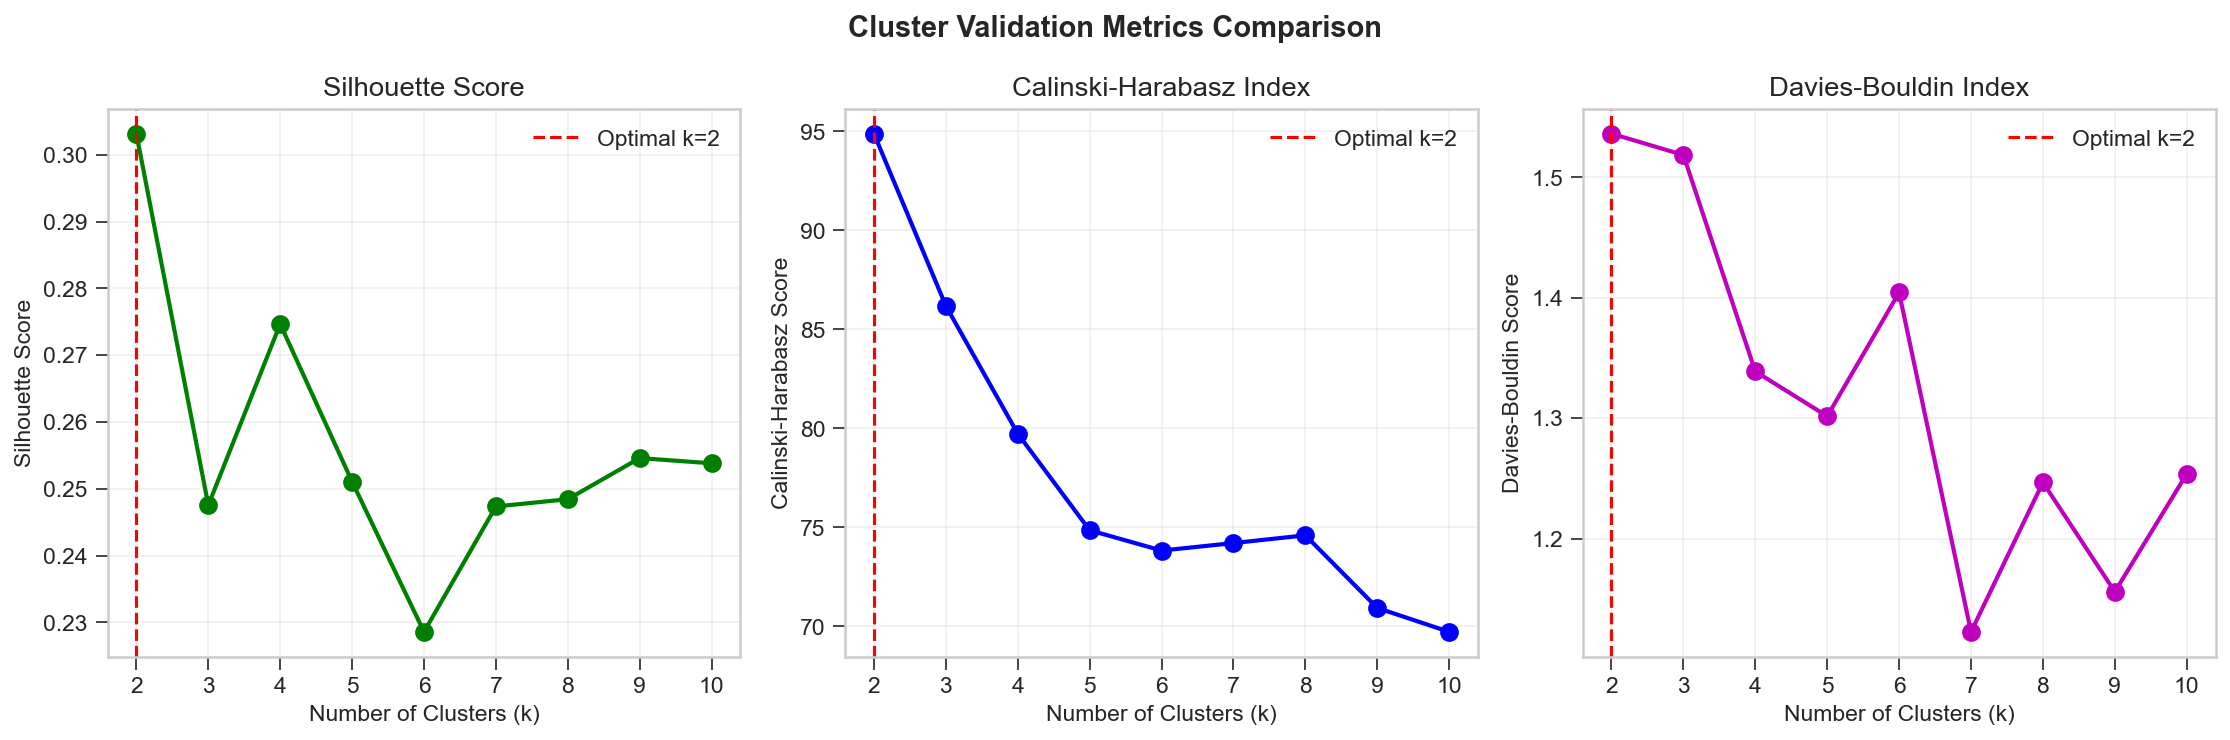

In [9]:
#cluster optimization 

def optimize_clustering(pca_scores, k_range=None):
    """
    optimal cluster number can be determined using 
    - Silhouette Score: Measures cohesion within clusters and separation between clusters
    - Calinski-Harabasz Index: Evaluates ratio of between-cluster to within-cluster dispersion
    - Davies-Bouldin Index: Assesses average similarity between clusters and their most similar cluster
    """   
    if k_range is None:
        k_range = range(2, min(10, pca_scores.shape[0] // 2) + 1)
    
    cluster_metrics = []
    
    for k in k_range:
        # Fit K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(pca_scores)
        
        # Calculate validation metrics
        silhouette = silhouette_score(pca_scores, labels)
        calinski_harabasz = calinski_harabasz_score(pca_scores, labels)
        davies_bouldin = davies_bouldin_score(pca_scores, labels)
        
        cluster_metrics.append({
            "k": k,
            "silhouette": silhouette,
            "calinski_harabasz": calinski_harabasz,
            "davies_bouldin": davies_bouldin
        })
        
        print(f"k={k}: Silhouette={silhouette:.3f}, Calinski-Harabasz={calinski_harabasz:.1f}, Davies-Bouldin={davies_bouldin:.3f}")
    
    # optimal k determination is based on silhouette score -> k = 2 best value, second choise k = 4 -> how include calinski_harabasz_score and davies_bouldin_score?
    optimal_k = max(cluster_metrics, key=lambda x: x["silhouette"])["k"]
    best_silhouette = max(cluster_metrics, key=lambda x: x["silhouette"])["silhouette"]
    
    return optimal_k, cluster_metrics

# Calculating the optimized cluster number
optimal_k, cluster_validation_results = optimize_clustering(pca_scores)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

k_values = [result["k"] for result in cluster_validation_results]
silhouette_scores = [result["silhouette"] for result in cluster_validation_results]
calinski_scores = [result["calinski_harabasz"] for result in cluster_validation_results]
davies_scores = [result["davies_bouldin"] for result in cluster_validation_results]

# Normalize Calinski-Harabasz and invert Davies-Bouldin for comparison
calinski_normalized = np.array(calinski_scores) / max(calinski_scores)
davies_inverted = 1 - np.array(davies_scores) / max(davies_scores)

# plot_1: Silhouette Score
axes[0].plot(k_values, silhouette_scores, "go-", linewidth=2, markersize=8)
axes[0].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[0].set_title("Silhouette Score")
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Silhouette Score")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# plot_2: Calinski-Harabasz Index
axes[1].plot(k_values, calinski_scores, "bo-", linewidth=2, markersize=8)
axes[1].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[1].set_title("Calinski-Harabasz Index")
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("Calinski-Harabasz Score")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# plot_3: Davies-Bouldin Index
axes[2].plot(k_values, davies_scores, "mo-", linewidth=2, markersize=8)
axes[2].axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
axes[2].set_title("Davies-Bouldin Index")
axes[2].set_xlabel("Number of Clusters (k)")
axes[2].set_ylabel("Davies-Bouldin Score")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle("Cluster Validation Metrics Comparison", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.savefig("cluster_optimization_metrics.pdf", dpi=300, format="pdf")
plt.show()

In [10]:
# optimal k is selected by visual inspection of the silhouette score
optimal_k = 4  

Outliers detected: 15 (5.2%)
Normal samples: 276


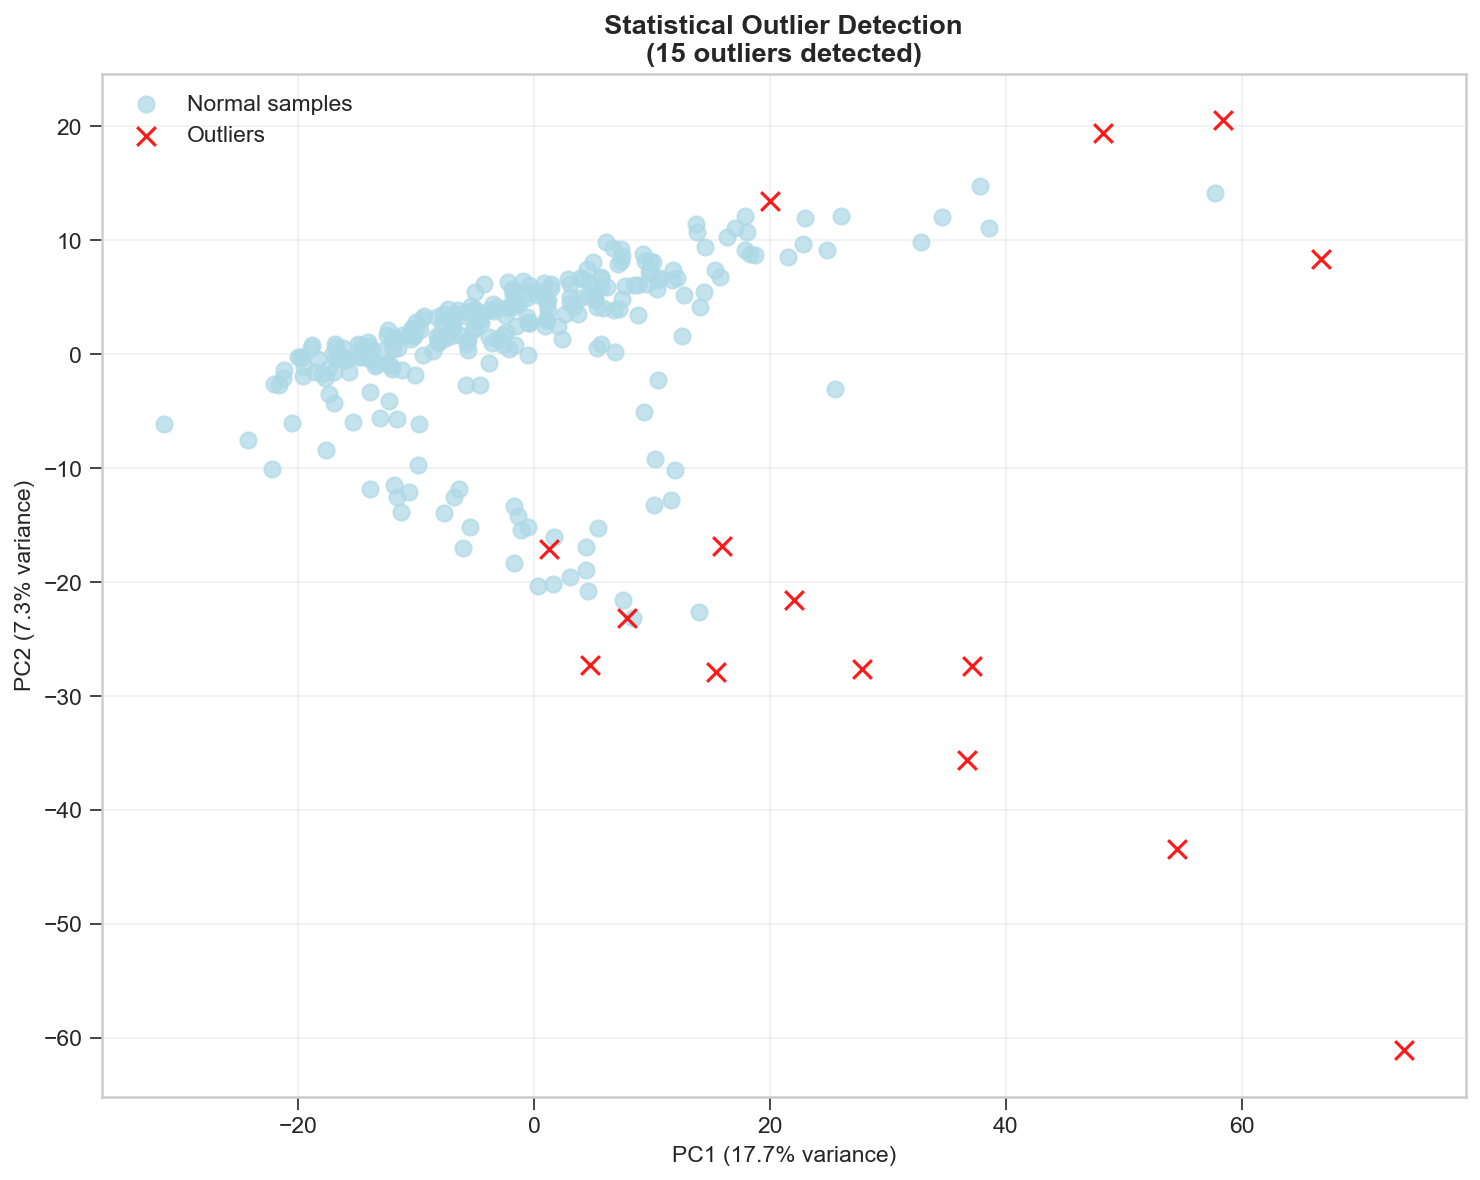

In [11]:
# Outlier detection

def detect_outliers(pca_scores, contamination=0.05):
    """
    - Elliptic Envelope method is used to identify statistical outliers.
    """
    
    envelope = EllipticEnvelope(contamination=contamination, random_state=42)
    outlier_labels = envelope.fit_predict(pca_scores)
    
    n_outliers = (outlier_labels == -1).sum()
    outlier_percentage = (n_outliers / len(outlier_labels)) * 100

    print(f"Outliers detected: {n_outliers} ({outlier_percentage:.1f}%)")
    print(f"Normal samples: {(outlier_labels == 1).sum()}")    
    return outlier_labels, n_outliers

# Perform outlier detection
outlier_labels, n_outliers = detect_outliers(pca_scores, contamination=0.05)

# Visualize outliers in PCA
plt.figure(figsize=(10, 8))

# Plot normal samples/ matrix without outlier
normal_mask = outlier_labels == 1
plt.scatter(pca_scores[normal_mask, 0], pca_scores[normal_mask, 1], 
           c='lightblue', s=60, alpha=0.7, label='Normal samples')

# Plot outliers
outlier_mask = outlier_labels == -1
plt.scatter(pca_scores[outlier_mask, 0], pca_scores[outlier_mask, 1], 
           c='red', s=80, marker='x', alpha=0.9, label='Outliers')

plt.title(f'Statistical Outlier Detection\n({n_outliers} outliers detected)', 
          fontweight='bold')
plt.xlabel(f'PC1 ({explained_variance[0]:.1f}% variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1f}% variance)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outlier_detection_PCA.pdf", dpi=300, format="pdf")
plt.show()


Cluster 0: 42 samples
Cluster 1: 126 samples
Cluster 2: 102 samples
Cluster 3: 21 samples


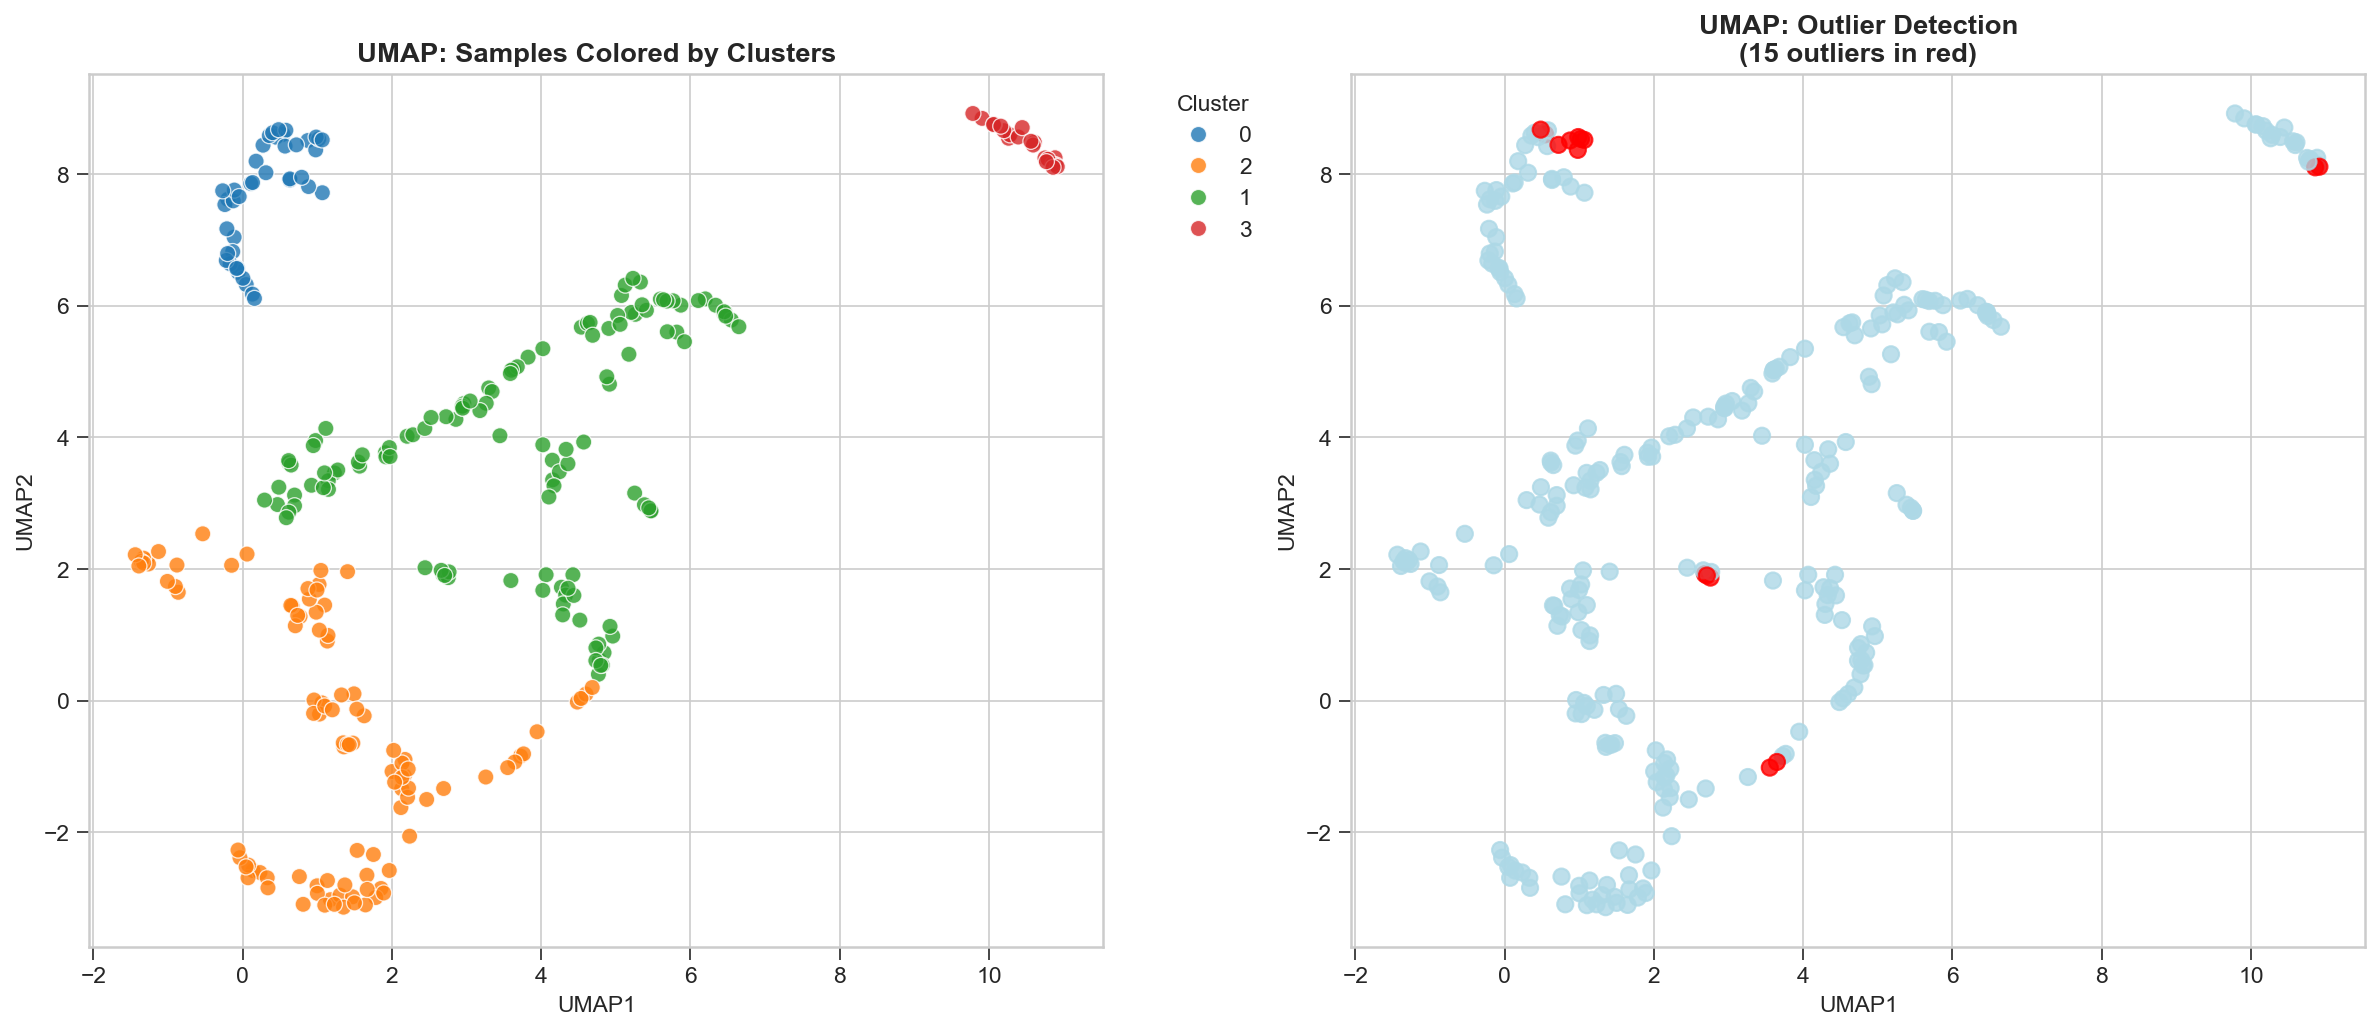

In [12]:
# UMAP clustering

def perform_umap_clustering(pca_scores, n_clusters, n_neighbors=10, min_dist=0.1):
    """
    - UMAP embedding and clustering.
    """
   
    # UMAP embedding from PCA scores
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, 
                       metric='euclidean', random_state=42) # random_state=42 makes analysis reproducible
    embedding = reducer.fit_transform(pca_scores)
    
    # Performing clustering on UMAP coordinates
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # random_state=42 makes analysis reproducible
    cluster_labels = kmeans.fit_predict(embedding)    

    unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)
    for cluster_id, count in zip(unique_clusters, cluster_counts):
        print(f"Cluster {cluster_id}: {count} samples")
    
    return embedding, cluster_labels, reducer

# Perform UMAP and clustering
umap_embedding, final_cluster_labels, umap_reducer = perform_umap_clustering(
    pca_scores, optimal_k, n_neighbors=10, min_dist=0.1
)

# Create UMAP visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# UMAP coloring the clusters
umap_df = pd.DataFrame(umap_embedding, columns=["UMAP1", "UMAP2"])
umap_df["Sample"] = expression_imputed.index
umap_df["Cluster"] = final_cluster_labels.astype(str)

sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Cluster",
               palette="tab10", s=60, alpha=0.8, ax=axes[0])
axes[0].set_title(f"UMAP: Samples Colored by Clusters", fontweight="bold")
axes[0].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# UMAP coloring the outlier 
outlier_colors = ['red' if x == -1 else 'lightblue' for x in outlier_labels]
axes[1].scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=outlier_colors, 
               s=60, alpha=0.8)
axes[1].set_title(f"UMAP: Outlier Detection\n({n_outliers} outliers in red)", fontweight="bold")
axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")

plt.tight_layout()
plt.savefig("UMAP_comprehensive_analysis.pdf", dpi=300, format="pdf")
plt.show()

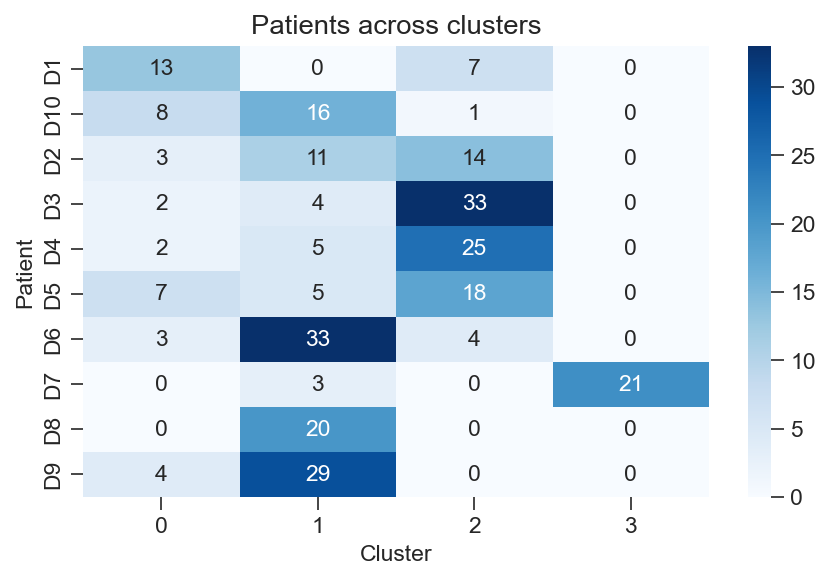

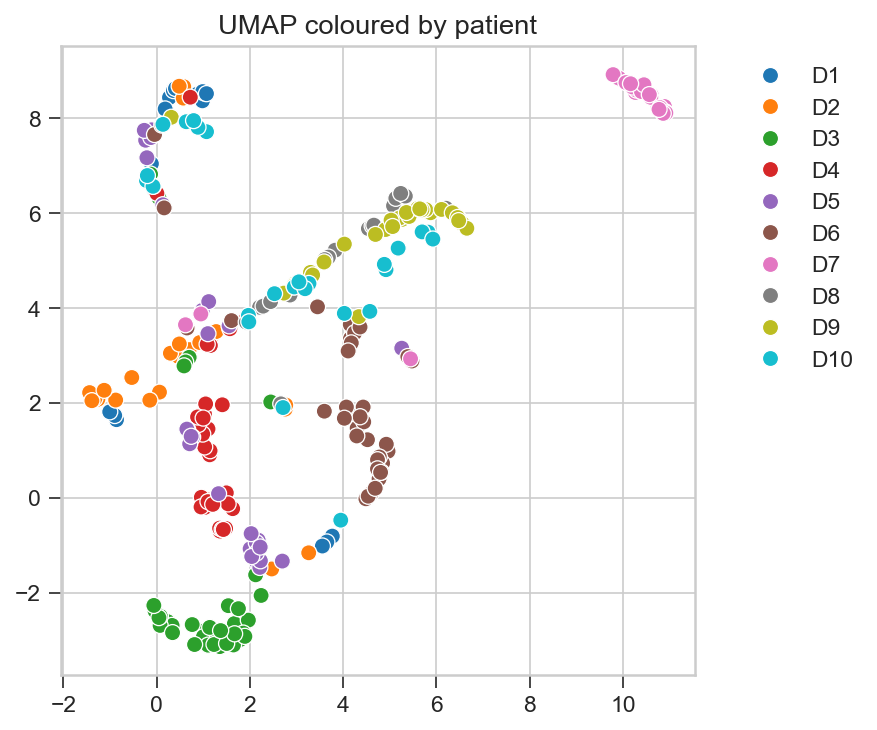

In [13]:

# To show the patient-iD (e.g.D3_R12) in the UMAP or analysis:
patient_id = expression_imputed.index.str.extract(r'^(D\d+)_', expand=False)
umap_df['Patient'] = patient_id.values      

#Cross table: Patient × Cluster
ct = pd.crosstab(umap_df['Patient'], umap_df['Cluster'])

# Cross table: Patient × Outlier
outlier_flag = np.where(outlier_labels == -1, 'Outlier', 'Normal')
ot = pd.crosstab(umap_df['Patient'], outlier_flag)

#Heatmap: Patient distribution via clusters
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title("Patients across clusters"); plt.ylabel("Patient"); plt.xlabel("Cluster")
plt.tight_layout(); plt.savefig("patient_vs_cluster.pdf")

# UMAP: coloured patient samples
plt.figure(figsize=(6,5))
sns.scatterplot(x=umap_embedding[:,0], y=umap_embedding[:,1],
                hue=patient_id, palette="tab10", s=60)
plt.title("UMAP coloured by patient"); plt.legend(bbox_to_anchor=(1.05,1))
plt.tight_layout(); plt.savefig("UMAP_by_patient.pdf")
plt.show()

In [14]:
# which cells are the outlier? Is there a trend toward one patient?
outlier_mask = (outlier_labels == -1)
outlier_df   = pd.DataFrame({
    'Sample'  : expression_imputed.index[outlier_mask],
    'Patient' : patient_id[outlier_mask].values,
    'Cluster' : final_cluster_labels[outlier_mask]
}).reset_index(drop=True)

outlier_df.to_csv("outlier_patient_list.csv", index=False)


In [15]:
# which cell belongs to which sample and is in which cluster?
all_cells_df = pd.DataFrame({
    'Sample'  : expression_imputed.index,               
    'Patient' : patient_id.values,                      
    'Cluster' : final_cluster_labels                    
}).reset_index(drop=True)

all_cells_df.to_csv("all_cells_patient_cluster.csv", index=False)

In [16]:
# Dictionary based on marker genes and UniProt search
gene_to_acc = {
    "BPI": "P17213",
    "CTSG": "P08311",
    "FCN1": "O00602",
    "ITGAM": "P11215",
    "ITGB2": "P05107",
    "SERPINB1": "P30740",
    "SPN": "P16150",
    "LCN1": "P31025",
    "LYZ": "P61626",      
    "MMP9": "P14780",
    "MPO": "P05164",
    "MMP8": "P22894",
    "NCF2": "P19878",
    "NCF4": "Q15080",
    "ELANE": "P08246",
    "LCN2": "P80188",
    "S100A8": "P05109",
    "S100A9": "P06702"
}

# Which are in my matrix?
present_genes = [g for g, acc in gene_to_acc.items() if acc in expression_matrix.columns]
print(f"Present in dataset: {len(present_genes)} of {len(gene_to_acc)}")
print(f"Found: {present_genes}")

Present in dataset: 18 of 18
Found: ['BPI', 'CTSG', 'FCN1', 'ITGAM', 'ITGB2', 'SERPINB1', 'SPN', 'LCN1', 'LYZ', 'MMP9', 'MPO', 'MMP8', 'NCF2', 'NCF4', 'ELANE', 'LCN2', 'S100A8', 'S100A9']


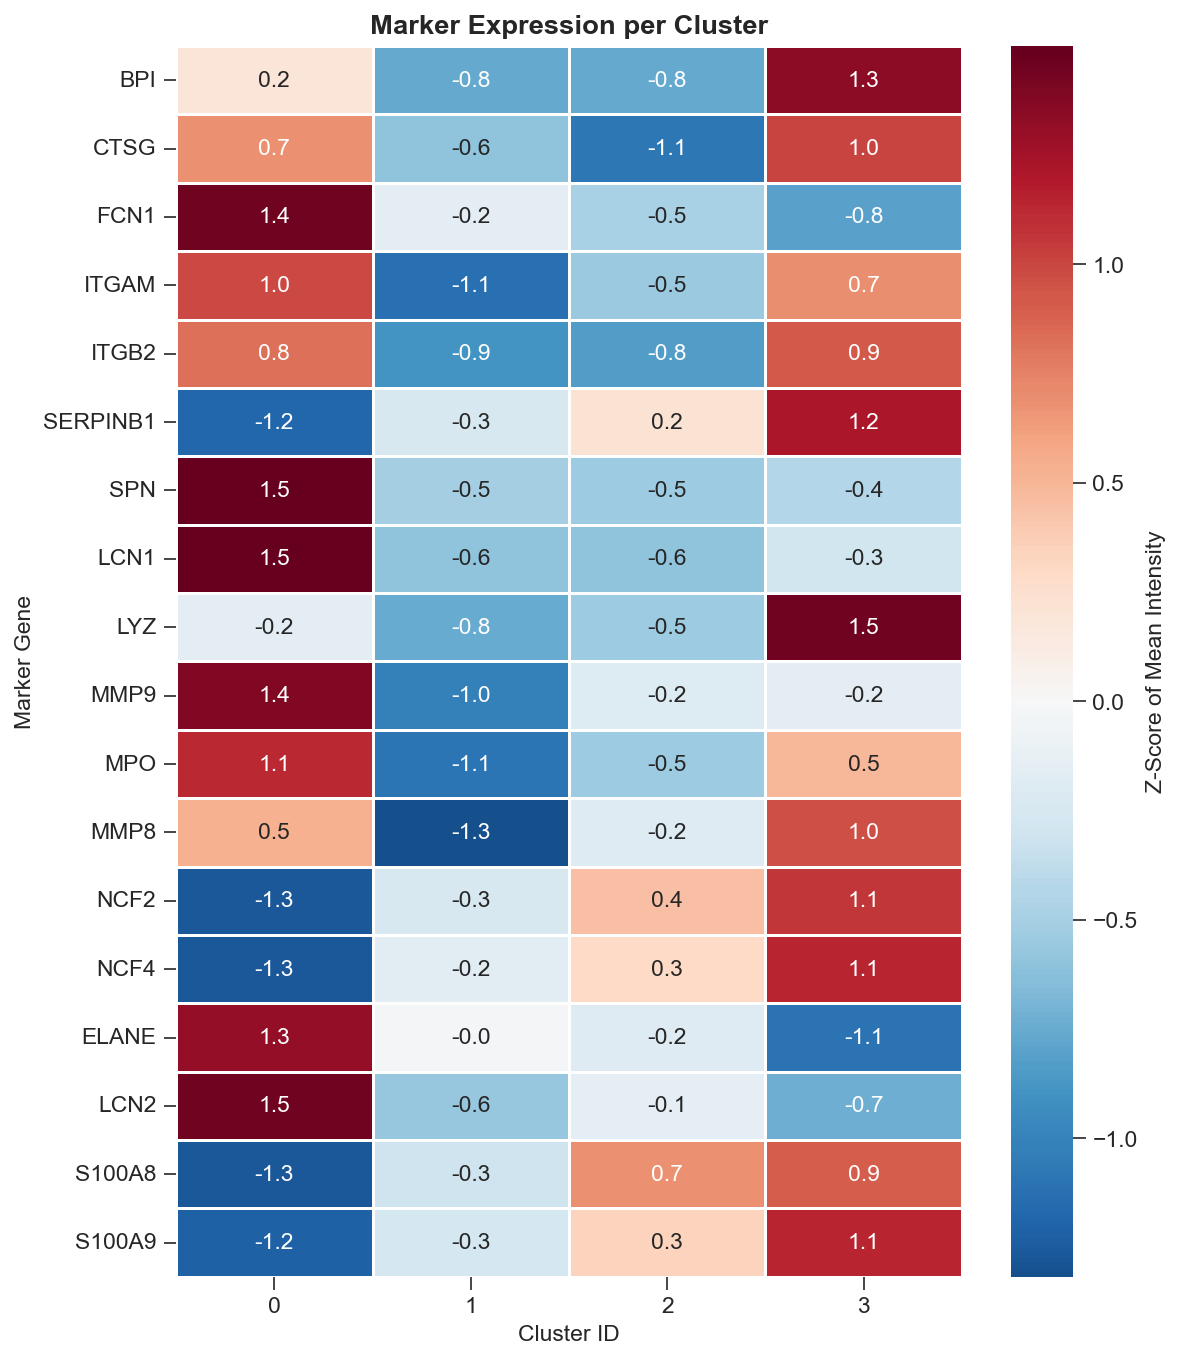

In [17]:
found_genes_map = {g: acc for g, acc in gene_to_acc.items() if acc in expression_matrix.columns} #Only the founded genes

if len(found_genes_map) > 0:
    heatmap_data = pd.DataFrame()
    heatmap_data['Cluster'] = final_cluster_labels
    
    for gene, acc in found_genes_map.items():
        heatmap_data[gene] = expression_matrix[acc].values #original values NaN included
    
    cluster_means = heatmap_data.groupby('Cluster').mean() # Aggregate: Mean expression per cluster, Pandas ignores NaN
    
    # Z-score normalisation: 
    cluster_means_z = (cluster_means - cluster_means.mean()) / cluster_means.std()
    
    # Transpose -> clusters on x-axis gene on y axis
    plot_matrix = cluster_means_z.T 
   
    plt.figure(figsize=(8, len(plot_matrix) * 0.4 + 2))
    
    sns.heatmap(
        plot_matrix,
        cmap='RdBu_r',       # red for high, blue for low 
        center=0,            # white for 0
        annot=True,          
        fmt='.1f',           
        linewidths=0.5,
        cbar_kws={'label': 'Z-Score of Mean Intensity'}
    )
    
    plt.title("Marker Expression per Cluster", fontweight="bold")
    plt.xlabel("Cluster ID")
    plt.ylabel("Marker Gene")
    plt.tight_layout()
    plt.savefig("marker_heatmap.pdf")
    plt.show()      

else:
    print("None of the genes are in the clusters")

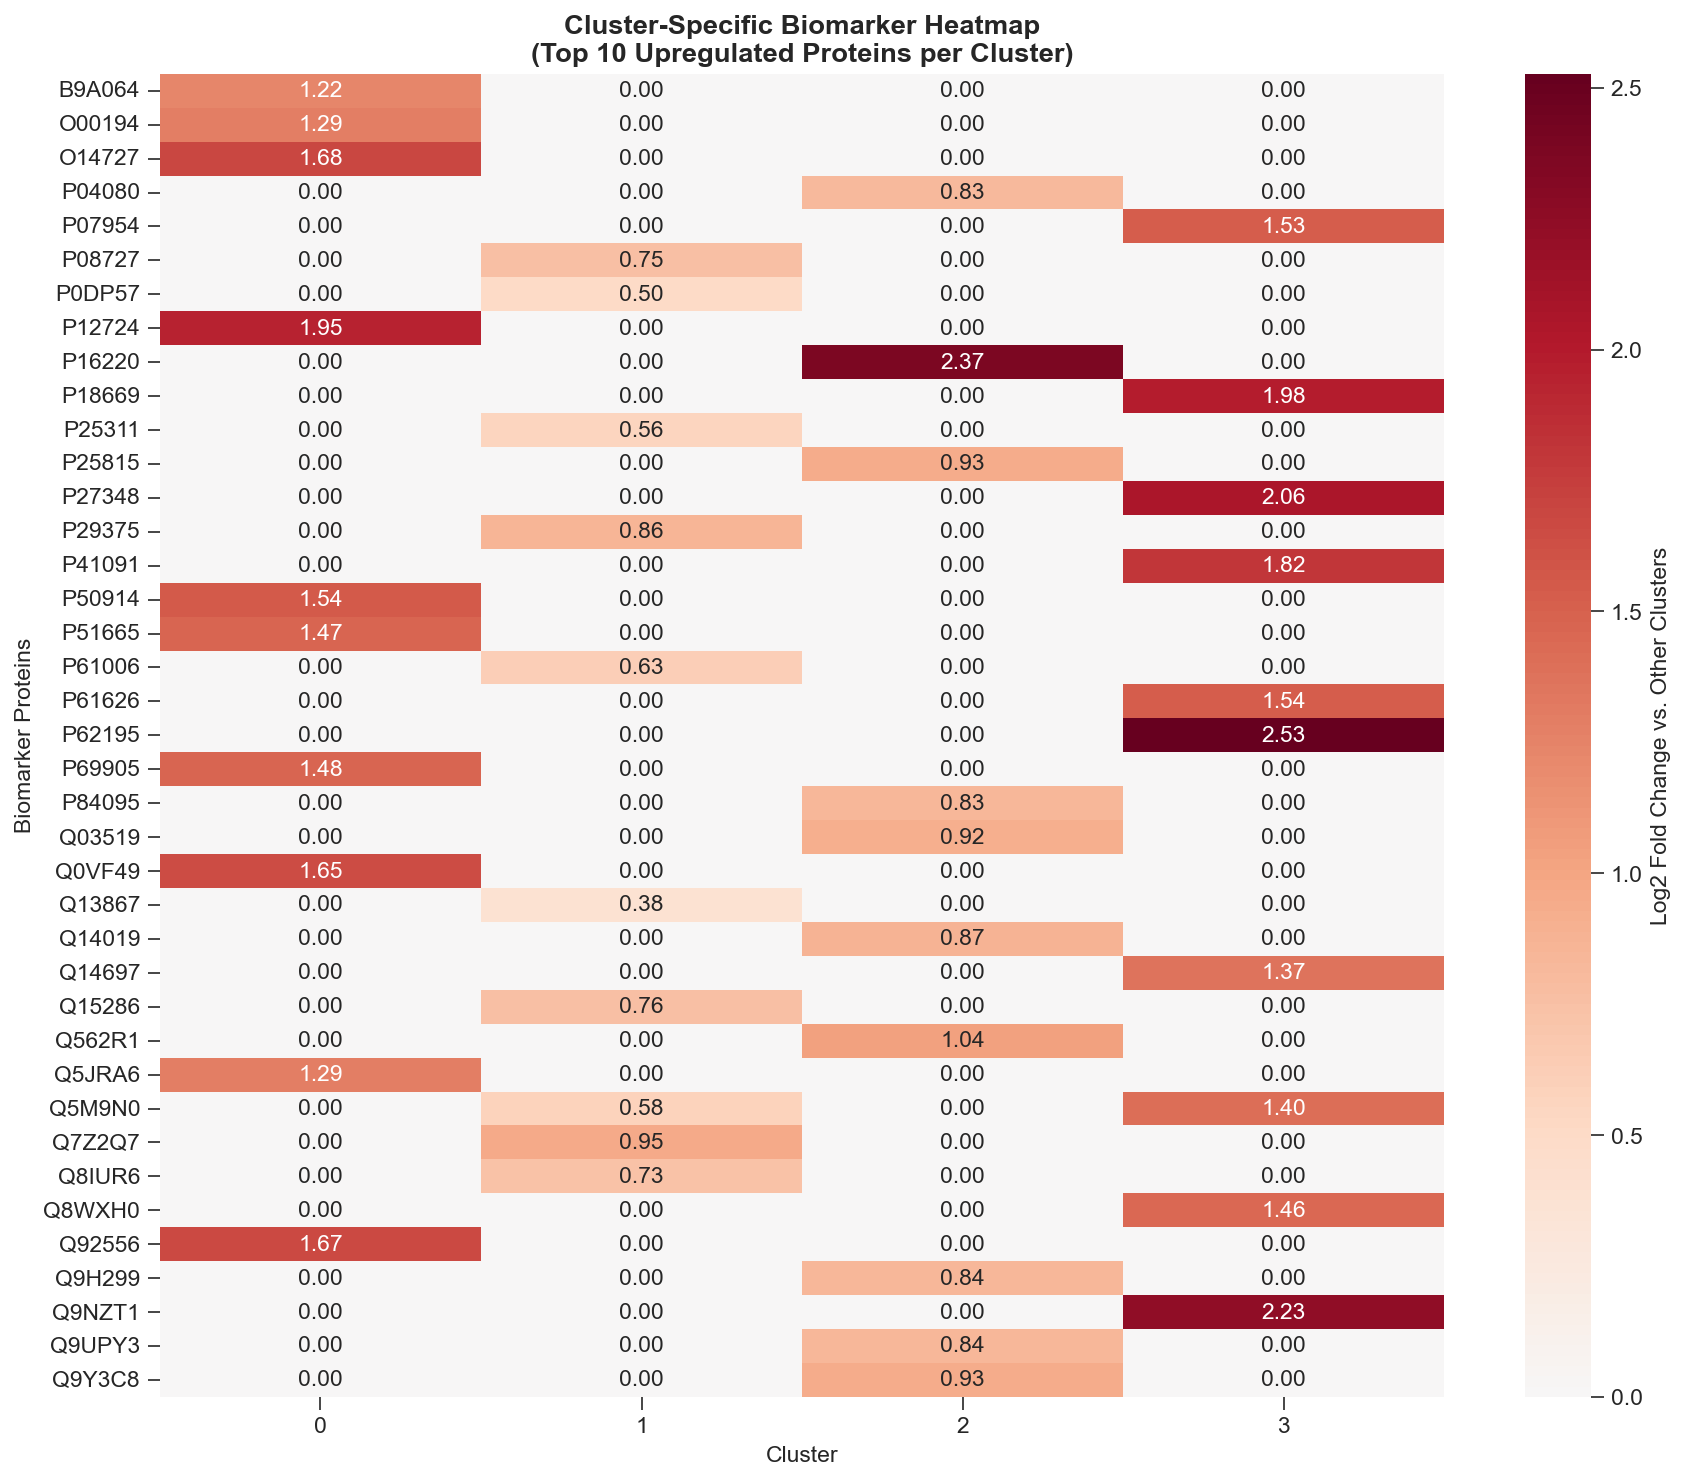

In [18]:
def identify_cluster_biomarkers(expression_imputed, cluster_labels, top_n_per_cluster=10):
    """
    -showing top proteins for each cluster.
    """
  
    unique_clusters = np.unique(cluster_labels)
    all_biomarkers = []
    
    for cluster_id in unique_clusters:
        cluster_mask = cluster_labels == cluster_id
        other_mask = ~cluster_mask
        
        cluster_mean = expression_imputed.loc[cluster_mask].mean()
        other_mean = expression_imputed.loc[other_mask].mean()
        
        fold_change = np.log2((cluster_mean + 1e-8) / (other_mean + 1e-8))
        
        top_proteins = fold_change.nlargest(top_n_per_cluster)
        
        for protein in top_proteins.index:
            all_biomarkers.append({
                'cluster': cluster_id,
                'protein': protein,
                'fold_change': top_proteins[protein],
                'cluster_mean': cluster_mean[protein],
                'other_mean': other_mean[protein]
            })
    
    biomarkers_df = pd.DataFrame(all_biomarkers)
    
    biomarker_matrix = biomarkers_df.pivot(index='protein', columns='cluster', values='fold_change')
    biomarker_matrix = biomarker_matrix.fillna(0)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        biomarker_matrix,
        cmap='RdBu_r',
        center=0,
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'Log2 Fold Change vs. Other Clusters'}
    )
    plt.title('Cluster-Specific Biomarker Heatmap\n(Top 10 Upregulated Proteins per Cluster)', 
             fontweight='bold')
    plt.xlabel('Cluster')
    plt.ylabel('Biomarker Proteins')
    plt.tight_layout()
    plt.savefig("cluster_biomarker_heatmap.pdf", dpi=300, format="pdf")
    plt.show()
    
    return biomarkers_df

cluster_biomarkers = identify_cluster_biomarkers(expression_imputed, final_cluster_labels, top_n_per_cluster=10)
cluster_biomarkers.to_csv("cluster_biomarkers.csv", index=False)
